### Notebook for looking into ETA (Event Triggered Averages) with singel cell data of (activated, inhibited, and non-selective cells) and neural behavior alignment


#### Imports and load data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy

import sys
#Add the caliban folder to path. In this case, it is just the parent folder.
sys.path.append('/Users/andresvillegas/Documents/code/Repo/caliban')
sys.path.append('/Users/andresvillegas/Documents/code/Repo/CaImAn')
sys.path.append('/Users/andresvillegas/Documents/code/code')

import analysis.resampling as Re
import analysis.visualize as vis
import analysis.analysis_utils as au

%matplotlib inline
plt.style.use('/Users/andresvillegas/Documents/code/Repo/caliban/jebstyle.mplstyle')

In [4]:
def event_trig_plt(mouse, behavior, min_time = 0, time = 1, allsess = True, trial = np.arange(1,3)):
    """ this funciton returns the event triggered activity for a given behavior
    mouse: the mouse object for a particular day
    behavior: the behavior of interest
    min_time: the minimum time the behavior has to occur for
    time: the time before and after the behavior of interest
    allsess: if true, returns the activity for all sessions, if false, returns the activity for a specific session
    trial: the trial of interest

    returns: the event triggered activity for a given behavior
    """
    # extracting the rates of the behavior
    beh_rates = mouse.rates()
    mice = {0:mouse}
    # extracting the interavals of behaviors when occuring
    beh_intervals = au.extract_epochs(mice[0],f"{behavior}")[1]
    # filtering the intervals to only include intervals that are longer than the minimum time
    beh_intervals = au.filter_epochs(beh_intervals,framerate=mice[0].FR,seconds=min_time)
    start_range, stop_range = au.behavior_start_stop(beh_intervals, time, mice[0].FR)
    xax = np.arange(-time,time,1/mice[0].FR)
    act_start_array = np.zeros(shape=(len(xax), len(mouse.cell_transients.columns), 1))
    act_stop_array = np.zeros(shape=(len(xax), len(mouse.cell_transients.columns), 1))
    
    for i in stop_range:
        act_stop = np.array(mouse.cell_transients.loc[i[0]:i[1],:].reset_index(drop=True))[:,:,np.newaxis]
        if (len(act_stop) == len(xax)):
            act_stop_array = np.concatenate([act_stop_array, act_stop], axis=2)
    
    for i in start_range:
        act_start = np.array(mouse.cell_transients.loc[i[0]:i[1],:].reset_index(drop=True))[:,:,np.newaxis]
        if (len(act_start) == len(xax)):
            act_start_array = np.concatenate([act_start_array, act_start], axis=2)

    if allsess == True:
        activity_start = act_start_array
        activity_stop = act_stop_array
        
    else:
        activity_start = act_start_array[:,:,trial]
        activity_stop = act_stop_array[:,:,trial]

    neurons = beh_rates['neuron'].reset_index()['index']
    temp_start = pd.DataFrame(tuple(activity_start[:,neurons,:].mean(axis=2)))
    temp_stop = pd.DataFrame(tuple(activity_stop[:,neurons,:].mean(axis=2)))
    
    return temp_start, temp_stop, xax, beh_intervals

def plot_eta(eta, xax, ax, color='k'):
    mu = np.mean(eta,1)
    se = np.std(eta,1)/np.sqrt(eta.shape[1])
    #fig,ax = plt.subplots(figsize=(2.5,2.5))

    ax.plot(xax,mu, linewidth=1, color=color)
    ax.fill_between(xax,mu+se,mu-se, zorder=0, alpha=.3, color=color)
    ax.axvline(x=0,color='r',linestyle='--')
    ax.set_xlabel('Time Relative \nto Behavior (s)')
    ax.set_ylabel('Average Z-scored \nActivity')

def plot_eta_mean(eta, xax, ax, color='k'):
    mu = np.mean(eta,1)
    #fig,ax = plt.subplots(figsize=(2.5,2.5))

    ax.plot(xax,mu, linewidth=1, color=color)
    ax.axvline(x=0,color='r',linestyle='--')
    ax.set_xlabel('Time Relative \nto Behavior (s)')
    ax.set_ylabel('Average Z-scored \nActivity')

def plot_eta_se(eta, xax, ax, color='k'):
    mu = np.mean(eta,1)
    se = np.std(eta,1)/np.sqrt(eta.shape[1])
    #fig,ax = plt.subplots(figsize=(2.5,2.5))

    # ax.plot(xax,mu, linewidth=1, color=color)
    ax.fill_between(xax,mu+se,mu-se, zorder=0, alpha=.3, color=color)
    ax.axvline(x=0,color='r',linestyle='--')
    ax.set_xlabel('Time Relative \nto Behavior (s)')
    ax.set_ylabel('Average Z-scored \nActivity')

def plot_day(exp_start, dom_start, att_start, base_start, exp_stop, dom_stop, att_stop, base_stop, times_range, day):
    """ this function plots the start and stop of each day for each condition
    exp_start: the start of the experiment for each condition
    dom_start: the start of the dominance for each condition
    att_start: the start of the attention for each condition
    base_start: the start of the baseline for each condition
    exp_stop: the stop of the experiment for each condition
    dom_stop: the stop of the dominance for each condition
    att_stop: the stop of the attention for each condition
    base_stop: the stop of the baseline for each condition
    times_range: the time range for each condition
    day: the day of the experiment

    returns: a plot of the start and stop of each day for each condition
    """
    fig,ax = plt.subplots(1, 2, figsize=(4,2))
    plot_eta(exp_start, times_range, ax[0], color = 'blue')
    plot_eta(dom_start, times_range, ax[0], color = 'orange')
    plot_eta(att_start, times_range, ax[0], color = 'red')
    plot_eta(base_start, times_range, ax[0], color = 'grey')
    ax[0].set_title(f'{day}_start')

    plot_eta(exp_stop, times_range, ax[1], color = 'blue')
    plot_eta(dom_stop, times_range, ax[1], color = 'orange')
    plot_eta(att_stop, times_range, ax[1], color = 'red')
    plot_eta(base_stop, times_range, ax[1], color = 'grey')
    ax[1].set_title(f'{day}_stop')
    
    ax[0].set_ylim([.1, .3])
    ax[1].set_ylim([.1, .3])
    
    return fig

In [5]:
def get_selectivity_beh(mice, day, beh_selectivity):
    """ 
    mice is a dictionary of mice with keys as day1, day2, etc.
    day is a string of the day you want to look at
    beh_selectivity is a string of the behavior you want to look at
        
    returns a series of the number of cells that are selectve for that behavior
    """
    run_sum = []
    for i in range(len(mice)):
        if day in mice[i].keys():
            run_sum.append(mice[i][day].cell_selectivity[beh_selectivity].value_counts().sort_index())
        else:
            pass
    
    inter = pd.concat(run_sum, axis = 1)
    result = inter.sum(axis=1)
    return result

#### Loading in saved mouse data

In [4]:
# setting the path to the data
mouse_data_path = '/Users/andresvillegas/Documents/Experiments/Calcium_Imaging/single_cell_analysis/mice_objects/'

# loading the data
with open(mouse_data_path + 'exp14_m1_w_selectivity.pickle', 'rb') as f: exp14_m1 = pickle.load(f)
with open(mouse_data_path + 'exp25_m2_w_selectivity.pickle', 'rb') as f: exp25_m2 = pickle.load(f)
with open(mouse_data_path + 'exp32_m2_w_selectivity.pickle', 'rb') as f: exp32_m2 = pickle.load(f)
with open(mouse_data_path + 'exp40_m3_w_selectivity.pickle', 'rb') as f: exp40_m3 = pickle.load(f)
with open(mouse_data_path + 'exp40_m4_w_selectivity.pickle', 'rb') as f: exp40_m4 = pickle.load(f)
with open(mouse_data_path + 'exp47_m1_w_selectivity.pickle', 'rb') as f: exp47_m1 = pickle.load(f)
with open(mouse_data_path + 'exp50_m1_w_selectivity.pickle', 'rb') as f: exp50_m1 = pickle.load(f)
with open(mouse_data_path + 'exp50_m2_w_selectivity.pickle', 'rb') as f: exp50_m2 = pickle.load(f)
with open(mouse_data_path + 'exp47_m2_w_selectivity.pickle', 'rb') as f: exp47_m2 = pickle.load(f)

In [5]:
# attack days excluded
del exp32_m2['day1'], exp40_m4['day1'], exp47_m2['day1'],\
exp50_m1['day3'], exp32_m2['day4'], exp40_m4['day4'],\
exp40_m3['day5']

In [6]:
all_mice = [exp14_m1, exp25_m2, exp32_m2, exp40_m3, exp40_m4, exp47_m1, exp50_m1, exp50_m2, exp47_m2]

In [7]:
num = 8

for i in all_mice[num].keys():
    print(all_mice[num][i].name)

# day1 has 6 mice
# day2 has 9 mice
# day3 has 8 mice
# day4 has 7 mice
# day5 has 8 mice
# day6 has 9 mice

exp47_m2_dCA2_day2_mouse2_day2
exp47_m2_dCA2_day3_mouse2_day3
exp47_m2_dCA2_day4_mouse2_day4
exp47_m2_dCA2_day5_mouse2_day5
exp47_m2_dCA2_day6_mouse2_day6


#### continue with mouse preperation

In [8]:
def beh_selectivity(df, beh, beh_selectivity):
     # ex: df = all_mice[0]['day1'].cell_selectivity
     df = copy.deepcopy(df)
     selctive_cells = df.cell_selectivity[df.cell_selectivity[f"{beh}_nosocial_selectivity"] == f'{beh_selectivity}']['neuron'].values.astype(int)
     
     # spikes_and_beh
     string_columns = [col for col in df.spikes_and_beh.columns if isinstance(col, str)]
     final_columns = string_columns + [col for col in selctive_cells if col in df.spikes_and_beh.columns]
     df.spikes_and_beh = df.spikes_and_beh.loc[:,final_columns]

     # spikes
     string_columns = [col for col in df.spikes.columns if isinstance(col, str)]
     final_columns = string_columns + [col for col in selctive_cells if col in df.spikes.columns]
     df.spikes = df.spikes.loc[:,final_columns]

     # cell_transients
     string_columns = [col for col in df.cell_transients.columns if isinstance(col, str)]
     final_columns = string_columns + [col for col in selctive_cells if col in df.spikes.columns]
     df.cell_transients = df.cell_transients.loc[:,final_columns]

     # spikes_and_beh_time
     string_columns = [col for col in df.spikes_and_beh_time.columns if isinstance(col, str)]
     final_columns = string_columns + [col for col in selctive_cells if col in df.spikes.columns]
     df.spikes_and_beh_time = df.spikes_and_beh_time.loc[:,final_columns]

     return df

In [9]:
def store_mouse_eta(start_beh_neural, stop_beh_neural):
    """ This function is used to aggregate average neural start and stop times"""
    eta_start = start_beh_neural
    mu_start = np.mean(eta_start,1)
    se_start = np.std(eta_start,1)/np.sqrt(eta_start.shape[1])
    
    eta_stop = stop_beh_neural
    mu_stop = np.mean(eta_stop,1)
    se_stop = np.std(eta_stop,1)/np.sqrt(eta_stop.shape[1])
    
    return eta_start, mu_start, se_start, eta_stop, mu_stop, se_stop

In [10]:
def aggregate_eta_data(experi, name):
    """ This is a warpper function used to aggregate the data for different behaviors
    name in str format
    """

    if any(experi.spikes_and_beh.columns == 'attack'):
        data = {}

        data['temp_start_att'], data['temp_stop_att'], data['xax_att'], data['int_att'] = event_trig_plt(experi, 'attack', time=3)
        data['temp_start_exp'], data['temp_stop_exp'], data['xax_exp'], data['int_exp'] = event_trig_plt(experi, 'exploration', time=3)
        data['temp_start_dom'], data['temp_stop_dom'], data['xax_dom'], data['int_dom'] = event_trig_plt(experi, 'dominance', time=3)
        data['temp_start_base'], data['temp_stop_base'], data['xax_base'], data['int_base'] = event_trig_plt(experi, 'no_social_behavior', time=3)

        behavior_data = {}
        behavior_data['name'] = name

        behavior_data['attack'] = {}
        behavior_data['attack']['eta_start'], behavior_data['attack']['mu_start'], behavior_data['attack']['se_start'], behavior_data['attack']['eta_stop'], behavior_data['attack']['mu_stop'], behavior_data['attack']['se_stop'] = store_mouse_eta(data['temp_start_att'], data['temp_stop_att'])

        behavior_data['exploration'] = {}
        behavior_data['exploration']['eta_start'], behavior_data['exploration']['mu_start'], behavior_data['exploration']['se_start'], behavior_data['exploration']['eta_stop'], behavior_data['exploration']['mu_stop'], behavior_data['exploration']['se_stop'] = store_mouse_eta(data['temp_start_exp'], data['temp_stop_exp'])

        behavior_data['dominance'] = {}
        behavior_data['dominance']['eta_start'], behavior_data['dominance']['mu_start'], behavior_data['dominance']['se_start'], behavior_data['dominance']['eta_stop'], behavior_data['dominance']['mu_stop'], behavior_data['dominance']['se_stop'] = store_mouse_eta(data['temp_start_dom'], data['temp_stop_dom'])

        behavior_data['no_social_behavior'] = {}
        behavior_data['no_social_behavior']['eta_start'], behavior_data['no_social_behavior']['mu_start'], behavior_data['no_social_behavior']['se_start'], behavior_data['no_social_behavior']['eta_stop'], behavior_data['no_social_behavior']['mu_stop'], behavior_data['no_social_behavior']['se_stop'] = store_mouse_eta(data['temp_start_base'], data['temp_stop_base'])

    else:
        print(experi.name, ': no attack')
        data = {}

        data['temp_start_exp'], data['temp_stop_exp'], data['xax_exp'], data['int_exp'] = event_trig_plt(experi, 'exploration', time=3)
        data['temp_start_dom'], data['temp_stop_dom'], data['xax_dom'], data['int_dom'] = event_trig_plt(experi, 'dominance', time=3)
        data['temp_start_base'], data['temp_stop_base'], data['xax_base'], data['int_base'] = event_trig_plt(experi, 'no_social_behavior', time=3)

        behavior_data = {}
        behavior_data['name'] = name

        behavior_data['exploration'] = {}
        behavior_data['exploration']['eta_start'], behavior_data['exploration']['mu_start'], behavior_data['exploration']['se_start'], behavior_data['exploration']['eta_stop'], behavior_data['exploration']['mu_stop'], behavior_data['exploration']['se_stop'] = store_mouse_eta(data['temp_start_exp'], data['temp_stop_exp'])

        behavior_data['dominance'] = {}
        behavior_data['dominance']['eta_start'], behavior_data['dominance']['mu_start'], behavior_data['dominance']['se_start'], behavior_data['dominance']['eta_stop'], behavior_data['dominance']['mu_stop'], behavior_data['dominance']['se_stop'] = store_mouse_eta(data['temp_start_dom'], data['temp_stop_dom'])

        behavior_data['no_social_behavior'] = {}
        behavior_data['no_social_behavior']['eta_start'], behavior_data['no_social_behavior']['mu_start'], behavior_data['no_social_behavior']['se_start'], behavior_data['no_social_behavior']['eta_stop'], behavior_data['no_social_behavior']['mu_stop'], behavior_data['no_social_behavior']['se_stop'] = store_mouse_eta(data['temp_start_base'], data['temp_stop_base'])

    return data, behavior_data


#### mice data

In [19]:
def eta_day_neurons(day_beh, times_range, day):

    att_start = pd.concat([df['attack']['eta_start'] for df in day_beh], axis=1)
    att_stop  = pd.concat([df['attack']['eta_stop'] for df in day_beh], axis=1)
    att_start.columns = range(1, len(att_start.columns)+1)
    att_stop.columns  = range(1, len(att_stop.columns)+1)

    dom_start = pd.concat([df['dominance']['eta_start'] for df in day_beh], axis=1)
    dom_stop  = pd.concat([df['dominance']['eta_stop'] for df in day_beh], axis=1)
    dom_start.columns = range(1, len(dom_start.columns)+1)
    dom_stop.columns  = range(1, len(dom_stop.columns)+1)
    print(dom_start.shape)

    exp_start = pd.concat([df['exploration']['eta_start'] for df in day_beh], axis=1)
    exp_stop  = pd.concat([df['exploration']['eta_stop'] for df in day_beh], axis=1)
    exp_start.columns = range(1, len(exp_start.columns)+1)
    exp_stop.columns  = range(1, len(exp_stop.columns)+1)

    base_start = pd.concat([df['no_social_behavior']['eta_start'] for df in day_beh], axis=1)
    base_stop  = pd.concat([df['no_social_behavior']['eta_stop'] for df in day_beh], axis=1)
    base_start.columns = range(1, len(base_start.columns)+1)
    base_stop.columns  = range(1, len(base_stop.columns)+1)

    print('# neurons', dom_start.shape)
    print('# mice', len([i['name'] for i in day6_attack]))
    print('mice IDs', [i['name'] for i in day6_attack])

    fig,ax = plt.subplots(1, 2, figsize=(4,2))
    plot_eta(exp_start, times_range, ax[0], color = 'blue')
    plot_eta(dom_start, times_range, ax[0], color = 'orange')
    plot_eta(att_start, times_range, ax[0], color = 'red')
    ax[0].set_title(f'{day}_start')

    plot_eta(exp_stop, times_range, ax[1], color = 'blue')
    plot_eta(dom_stop, times_range, ax[1], color = 'orange')
    plot_eta(att_stop, times_range, ax[1], color = 'red')
    ax[1].set_title(f'{day}_stop')
    
    ax[0].set_ylim([0, .3])
    ax[1].set_ylim([0, .3])

    # Get all axes in the figure
    all_axes = fig.get_axes()

    # Choose the axis you want to remove (e.g., the second one, ax2)
    axis_to_remove = all_axes[1]

    # Remove the selected axis from the figure
    fig.delaxes(axis_to_remove)

    # put some text into this plot
    fig.text(0.17, 0.88, f"# mice: {len([i['name'] for i in day_beh])}", ha='center', va='center', fontsize = 4)
    fig.text(0.17, 0.85, f"Attack neurons: {att_start.shape[1]}", ha='center', va='center', fontsize = 4)
    fig.text(0.17, 0.82, f"Exploration neurons: {exp_start.shape[1]}", ha='center', va='center', fontsize = 4)
    fig.text(0.17, 0.79, f"Dominance neurons: {dom_start.shape[1]}", ha='center', va='center', fontsize = 4)
    # ax[0].set_ylim([.1, .3])
    # ax[1].set_ylim([.1, .3])
    plt.xlabel('')
    plt.ylabel('')
    return fig


In [62]:
beh = 'attack'
sel = 'activated'

# neurons (121, 63)
# mice 9
mice IDs ['exp14_m1_day6', 'exp14_m1_day6', 'exp32_m2_day6', 'exp47_m1_day6', 'exp50_m1_day6', 'exp50_m2_day6', 'exp40_m3_day6', 'exp40_m4_day6', 'exp47_m2_day6']


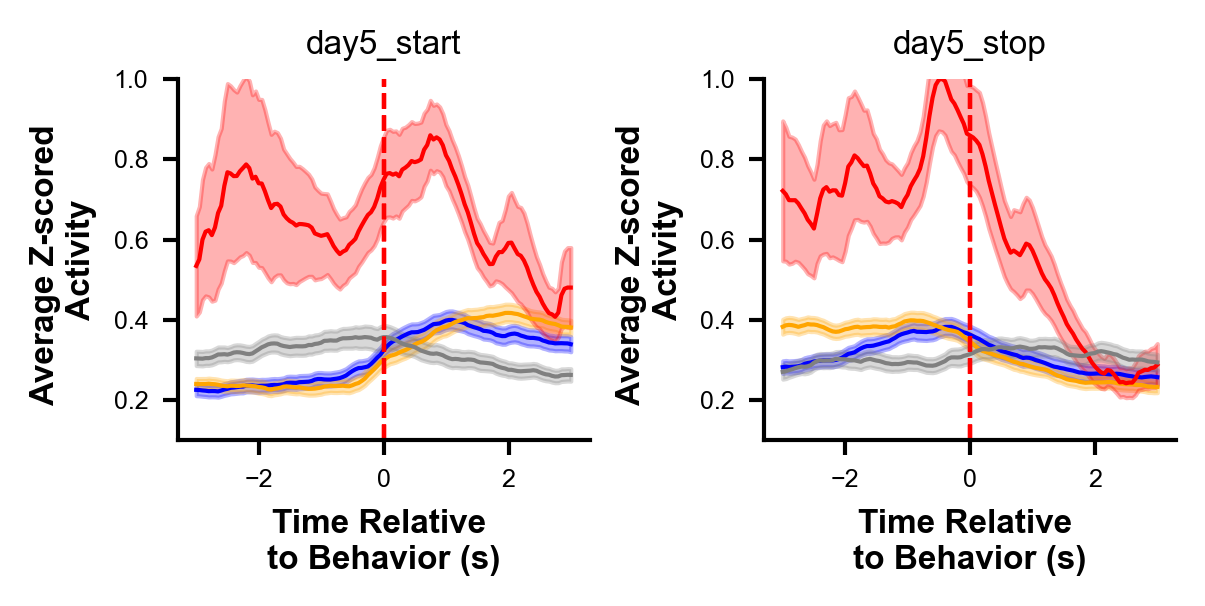

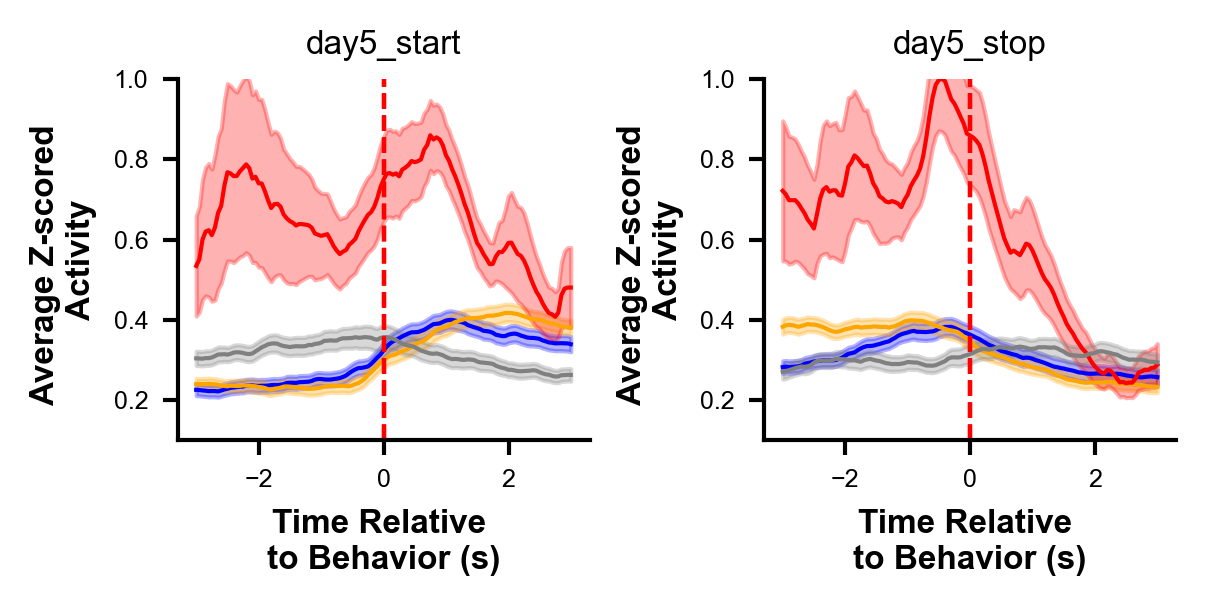

In [ ]:
eta_day_neurons(day5_behaviors_active, xax, 'day5')

# neurons (121, 55)
# mice 9
mice IDs ['exp14_m1_day6', 'exp14_m1_day6', 'exp32_m2_day6', 'exp47_m1_day6', 'exp50_m1_day6', 'exp50_m2_day6', 'exp40_m3_day6', 'exp40_m4_day6', 'exp47_m2_day6']


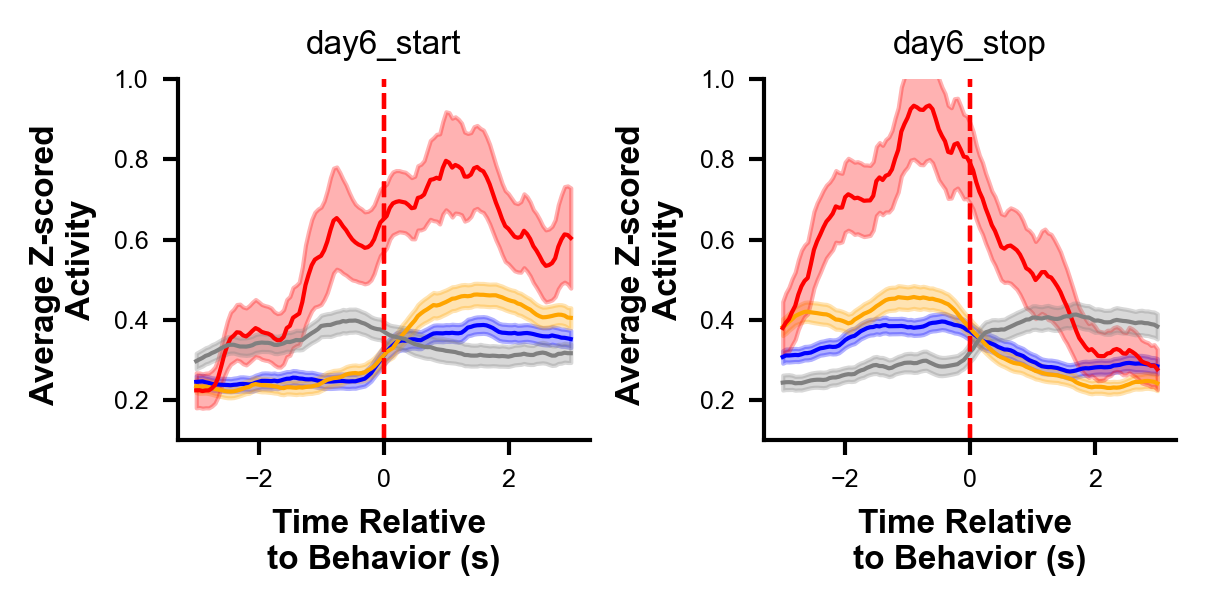

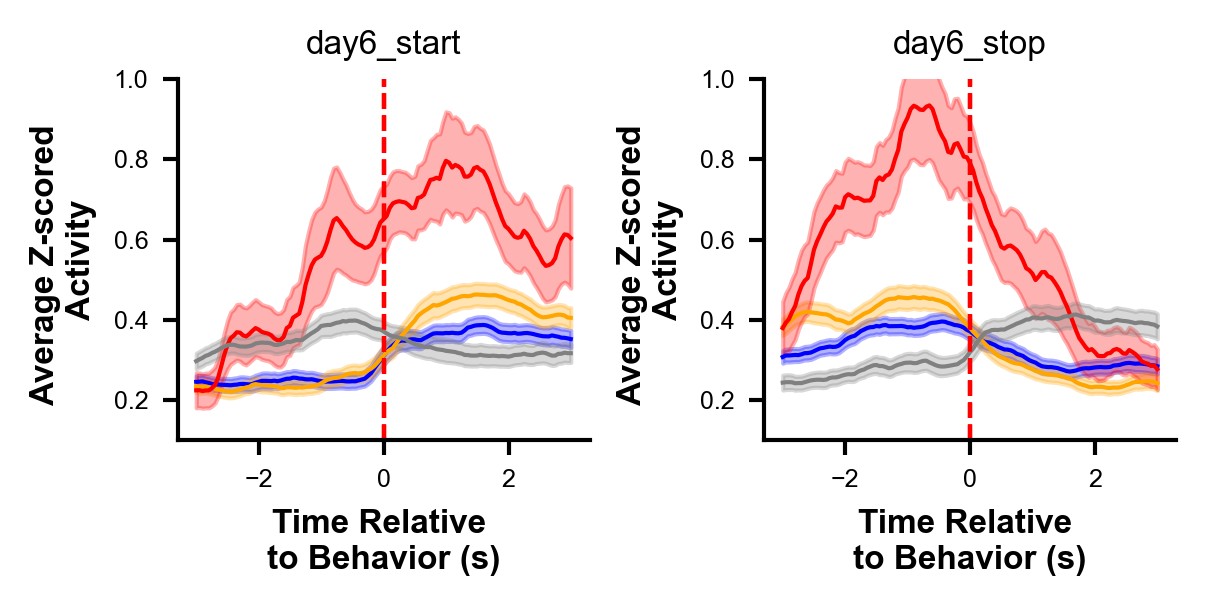

In [416]:
eta_day_neurons(day4_behaviors_active, xax, 'day6')